# Using manipulated data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tick
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
import os

## Read data

from 2020 paper we have <br/>

|     |  λ | α   |  β | Emp. E[N([0, 1])] |pdd |puu |σ| a∗|
| --- | --- | --- | --- | --- |--- |--- |--- |--- |
| AMZN | 0.6443 | 653.7524 | 1556.1702 | 1.1110|  0.4635| 0.4576| 0.0046 |−2.7373 × 10−5|

In this case, −δ will be state one, and δ with be state two.


standard parameter from the above table are not stable

In [3]:
stock = 'MSFT'
lob_level = 1
p = 'lobdataread'
msgfile = os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_message_{lob_level}.csv')
obfile =  os.path.join(os.getcwd(), f'{p}' ,"data", f'{stock}_2012-06-21_34200000_57600000_orderbook_{lob_level}.csv')
df1=pd.read_csv(msgfile, sep=',', header=None, 
        names=['time', 'type', 'ord_id', 'size', 'price', 'dir'],
        dtype={'time':np.float64, 'type':np.int32, 'ord_id':np.int32, 
               'size':np.int64, 'price':np.int64, 'dir':np.int32})

df2=pd.read_csv(obfile, sep=',', header=None, 
        names=['ask_prc_L1', 'ask_sz_L1', 'bid_prc_L1', 'bid_sz_L1'],
        dtype={'ask_prc_L1':np.float64, 'ask_sz_L1':np.int64, 'bid_prc_L1':np.float64, 'bid_sz_L1':np.int64})

df3 = pd.concat([df1, df2], axis=1)
df3 = df3.drop_duplicates(subset='time', keep='first')
df3['mid_price'] = (df3['ask_prc_L1'] + df3['bid_prc_L1'])/2
df3['datetime'] = pd.to_timedelta(df3['time'], unit='s') + pd.Timestamp("2012-06-21")
df3 = df3[(df3['datetime'].dt.time >= pd.Timestamp('2012-06-21 09:46:00').time()) & 
                 (df3['datetime'].dt.time <= pd.Timestamp('2012-06-21 15:44:00').time())]

In [4]:
df = df3[['time', 'datetime', 'mid_price']].copy()
df['mid_price'] = df['mid_price']/10000 
df.loc[:, 'mid_price'] = df['mid_price'] - df['mid_price'].iloc[0]
df.loc[:, 'time'] = df['time'] - df['time'].iloc[0]
df.reset_index(drop=True, inplace=True)
df['mid_diff'] = df['mid_price'].diff()
# Replace NaN with 0 at the beginning
df['mid_diff'].fillna(0, inplace=True)
threshold = 1e-6
df = df[df['mid_diff'].abs() >= threshold]
df.reset_index(drop=True, inplace=True)

In [5]:
df_positive = df[df['mid_diff'] >= 0]
df_negative = df[df['mid_diff'] < 0]
quantiles_positive = df_positive['mid_diff'].quantile(0.5)
quantiles_negative = df_negative['mid_diff'].quantile(0.5)
sc = quantiles_positive
quantiles_positive, quantiles_negative

(0.004999999999999005, -0.004999999999999005)

In [6]:
df['mid_diff'] = np.where(df['mid_diff'] >= 0, 0.01, -0.01)

In [7]:
df.isnull().any()

time         False
datetime     False
mid_price    False
mid_diff     False
dtype: bool

In [8]:
df = df[['time', 'datetime', 'mid_diff', 'mid_price']]

In [9]:
df.tail(2)

,time,datetime,mid_diff,mid_price
2885,21467.819184,2012-06-21 15:43:48.591711269,-0.01,-0.835
2886,21467.820647,2012-06-21 15:43:48.593173462,-0.01,-0.840


In [10]:
%%capture
timestamps_list = [df['time'].values]
best_score = -1e100
decay_candidates = np.linspace(0, 2000, 2000)
best_decay = 0
for i, decay in enumerate(decay_candidates):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000, tol=1e-10)
    hawkes_learner.fit(timestamps_list)

    hawkes_score = hawkes_learner.score()
    if hawkes_score > best_score:
        #print('obtained {}\n with {}\n'.format(hawkes_score, decay))
        best_hawkes = hawkes_learner
        best_score = hawkes_score
        best_decay = decay

In [11]:
#best_hawkes = hw
#best_decay = decay

In [12]:
print(f'n = {best_hawkes.n_nodes}',
      f'mu = {best_hawkes.baseline}', 
      f'alpha = {best_hawkes.adjacency}', '\n'
      f'beta = {best_decay}, alpha_p = {best_hawkes.adjacency * best_decay}')

n = 1 mu = [0.08937531] alpha = [[0.33527836]] 
beta = 2000.0, alpha_p = [[670.55671729]]


## Markov Process

In [13]:
df.head()

,time,datetime,mid_diff,mid_price
0,6.388885,2012-06-21 09:46:07.161411940,-0.01,-0.005
1,6.407330,2012-06-21 09:46:07.179857099,0.01,0.000
2,24.354930,2012-06-21 09:46:25.127457116,0.01,0.005
3,24.355953,2012-06-21 09:46:25.128480359,0.01,0.010
4,25.538072,2012-06-21 09:46:26.310598598,0.01,0.015


## Transition probability

In [14]:
df_origin = df.copy()

In [15]:
def compute_state(*args):
    state_str = ''.join(['1' if x > 0 else '0' for x in args])
    return int(state_str, 2)

def n_order_markov(df, n):
    # Create shifted columns for n previous values
    for i in range(1, n+1):
        col_name = f'prev{i}_mid_diff'
        df[col_name] = df['mid_diff'].shift(i)
        # Fill NaN values for simplicity
        for j in range(i):
            df.loc[j, col_name] = df['mid_diff'].iloc[0]
    
    # Compute the state
    columns_to_consider = [f'prev{i}_mid_diff' for i in range(1, n+1)] + ['mid_diff']
    df['state'] = df.apply(lambda row: compute_state(*(row[col] for col in columns_to_consider)), axis=1)
    
    # Drop the temporary columns
    df.drop(columns=[f'prev{i}_mid_diff' for i in range(1, n+1)], inplace=True)
    return df

# For example, for a 4th order Markov process:
n_order = 9
df = n_order_markov(df, n_order)
num_states = 2 ** (n_order+1)


In [16]:
df.head()

,time,datetime,mid_diff,mid_price,state
0,6.388885,2012-06-21 09:46:07.161411940,-0.01,-0.005,0
1,6.407330,2012-06-21 09:46:07.179857099,0.01,0.000,1
2,24.354930,2012-06-21 09:46:25.127457116,0.01,0.005,513
3,24.355953,2012-06-21 09:46:25.128480359,0.01,0.010,769
4,25.538072,2012-06-21 09:46:26.310598598,0.01,0.015,897


In [17]:
df.state.min(), df.state.max(), num_states

(0, 1023, 1024)

In [18]:
def compute_transition_matrix(df, n):
    num_states = 2 ** (n+1)
    transition_matrix = np.zeros((num_states, num_states))
    
    # Count transitions
    for i in range(len(df) - 1):
        current_state = df['state'].iloc[i]
        next_state = df['state'].iloc[i+1]
        transition_matrix[current_state, next_state] += 1
    
    # Normalize to get probabilities
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]
    
    return transition_matrix

# For a 4th order Markov process:
transition_matrix = compute_transition_matrix(df, n_order)


/opt/conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [19]:
# Assuming transition_probs is your transition matrix
P = np.array(transition_matrix)

# Create a matrix where each row is P - I
matrix = P.T - np.eye(P.shape[0])

# Replace the last row with ones to account for the probability constraint
matrix[-1, :] = 1

# Create the target vector, with a 1 at the end for the probability constraint
target = np.zeros(P.shape[0])
target[-1] = 1

# Solve the linear system
stationary_probs = np.linalg.solve(matrix, target)

print(stationary_probs)
print("================")
print(stationary_probs @ P)
print("================")
print(np.sum(stationary_probs))

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
nan


## Hawkes process

In [20]:
#best_hawkes = hw
#best_decay = decay

In [21]:
#best_hawkes.n_nodes, best_hawkes.baseline, best_hawkes.adjacency, best_decay
#best_hawkes.coeffs 

## General compound

\begin{equation}
v(i) = b(i)^2 + \sum_{j \in S} (g(j) - g(i))^2 P(i, j) - 2b(i) \sum_{j \in S} (g(j) - g(i)) P(i, j)
\end{equation}

In [22]:
def compute_v(b, g, P):
    """
    Compute v based on the given formula.
    
    Parameters:
    - i: the current state
    - b: a function or dictionary that gives b(i) for each i
    - g: a function or dictionary that gives g(i) for each i
    - P: a 2D array or dictionary of dictionaries that gives P(i, j) for each pair i, j    
    Returns:
    - v
    """
    v = np.zeros(b.shape)
    S = np.array([i for i in range(len(b))])
    for i in range(len(b)):
        term1 = b[i]**2
        term2 = np.sum([(g[j] - g[i])**2 * P[i][j] for j in S])
        term3 = -2 * b[i] * np.sum([(g[j] - g[i]) * P[i][j] for j in S])
        v[i] = term1 + term2 + term3
    
    return v

In [23]:
# np.dot(stationary_probs, transition_probs), stationary_probs

In [24]:
lam = best_hawkes.baseline
alpha = best_hawkes.adjacency
beta = best_decay
mu_hat = alpha# (alpha*beta)/beta
a = np.where(np.arange(num_states) % 2 == 0, -sc, sc)
a_star = np.dot(stationary_probs, a)
b = a - a_star
# # compute g 
P = transition_matrix
n_state_tot = P.shape[0]
Pi = np.tile(stationary_probs, (len(stationary_probs), 1))
# Identity matrix
I = np.eye(n_state_tot)
# Compute the inverse of P + Pi - I
g = np.linalg.inv(P + Pi - I)@ b
v =compute_v(b, g, P) 
sigma_2 = np.dot(stationary_probs, v)
sigma = np.sqrt(sigma_2)
sigma_star = sigma * np.sqrt(lam / (1 - mu_hat))

In [25]:
transition_matrix, sigma, a_star, mu_hat, lam

(array([[0.66101695, 0.33898305, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.82608696, 0.17391304, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.27272727,
         0.72727273],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.53333333,
         0.46666667]]),
 nan,
 nan,
 array([[0.33527836]]),
 array([0.08937531]))

In [26]:
df['mid_price2'] = np.cumsum(df['mid_diff'])
df['datetime'] = pd.to_datetime(df['datetime'])

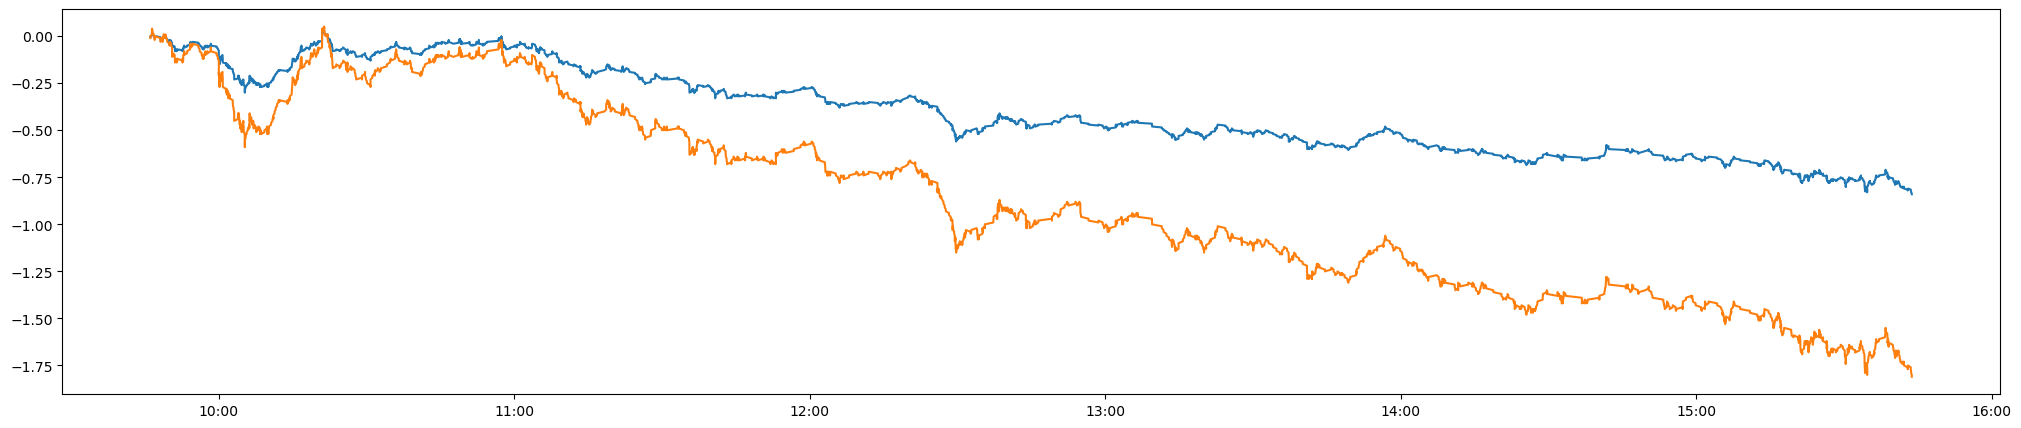

In [27]:
%matplotlib inline
import matplotlib
fig, ax = plt.subplots(1,1, figsize  = (25,5))
ax.plot(df.datetime, df.mid_price)
ax.plot(df.datetime, df.mid_price2)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))

In [28]:
df.tail()

,time,datetime,mid_diff,mid_price,state,mid_price2
2882,21455.324947,2012-06-21 15:43:36.097474174,-0.01,-0.820,388,-1.77
2883,21459.844610,2012-06-21 15:43:40.617136984,-0.01,-0.825,194,-1.78
2884,21459.845814,2012-06-21 15:43:40.618340518,-0.01,-0.830,96,-1.79
2885,21467.819184,2012-06-21 15:43:48.591711269,-0.01,-0.835,48,-1.80
2886,21467.820647,2012-06-21 15:43:48.593173462,-0.01,-0.840,24,-1.81


In [29]:
df_ = df
df_ = df.set_index('datetime')
windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
std_values = {}
std_values_theory = {}
for window in windows:
    window = str(window) + 'S'
    mid_price =  df_['mid_price'].resample(window).apply(lambda x: x[-1] - x[0])
    jump = df_['mid_price'].resample(window).size() * a_star
    p_result = mid_price - jump
                  
    std_value = p_result.dropna().std()
    std_values[window] = std_value
    n = float(window.replace('S',''))
    std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()

# Plotting the results
#std_values, std_values_theory

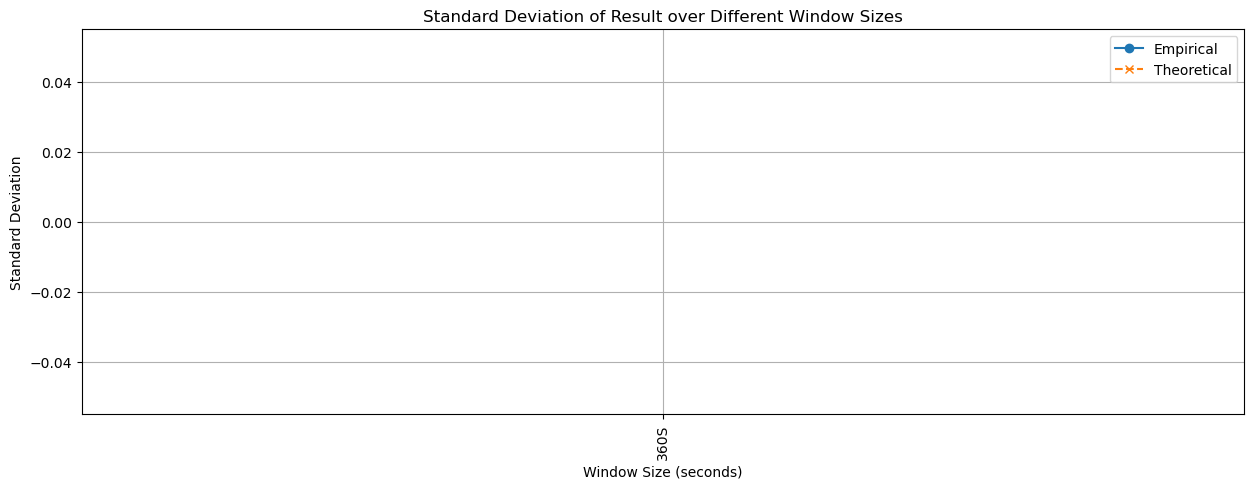

In [30]:
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

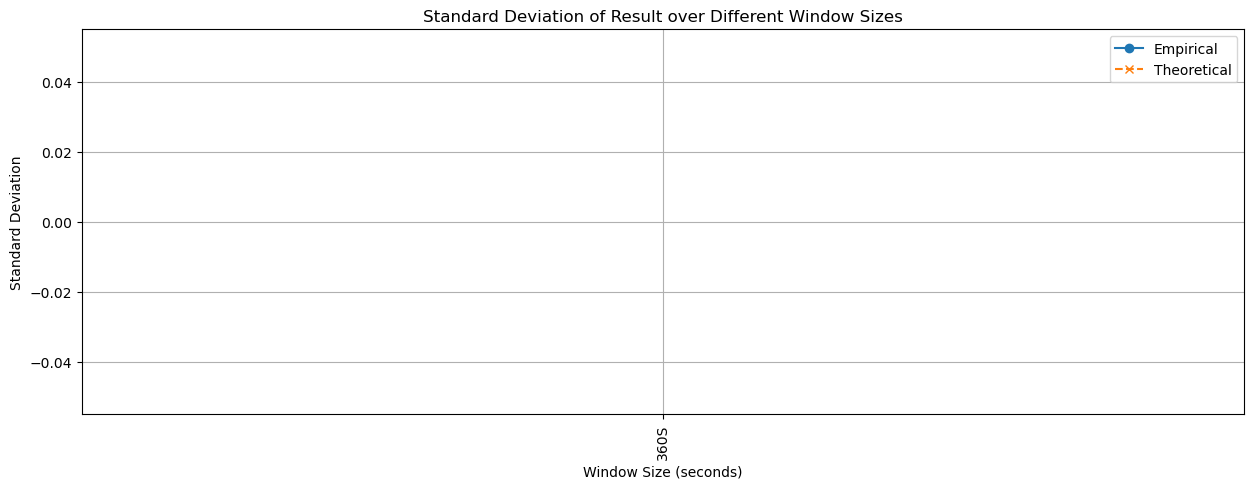

In [31]:
df_ = df
df_ = df.set_index('datetime')
windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
std_values = {}
std_values_theory = {}
for window in windows:
    window = str(window) + 'S'
    mid_price =  df_['mid_price2'].resample(window).apply(lambda x: x[-1] - x[0])
    jump = df_['mid_price2'].resample(window).size() * a_star
    p_result = mid_price - jump
                  
    std_value = p_result.dropna().std()
    std_values[window] = std_value
    n = float(window.replace('S',''))
    std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()

# Plotting the results
#std_values, std_values_theory
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

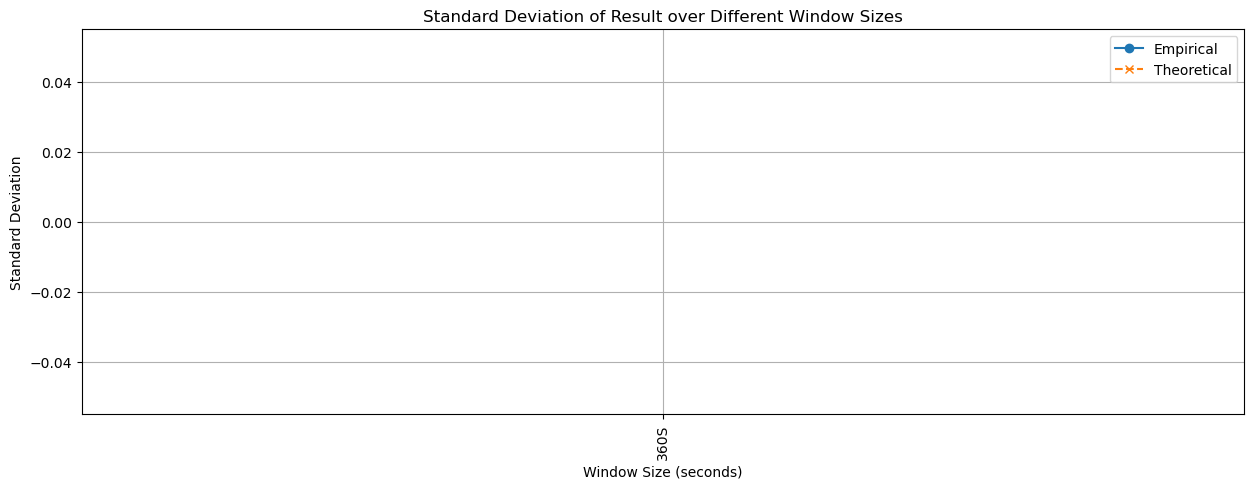

In [32]:
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

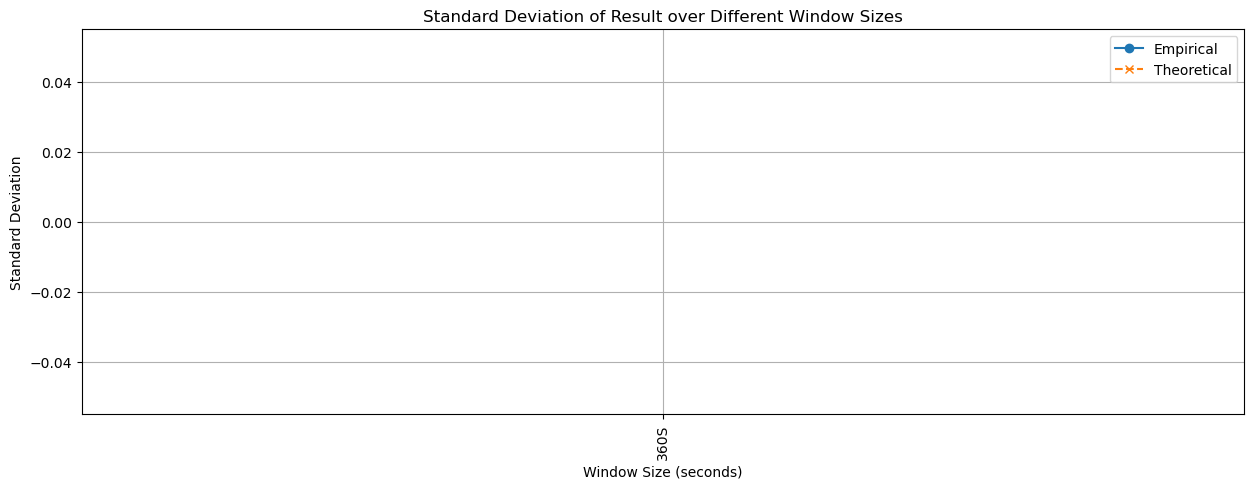

In [33]:
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()